In [1]:
import matplotlib.pyplot as plt
import numpy as np

################## SAM functions ############################
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [2]:
# 0. image rectification

# (논문 image matching and rectification 저장용)
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_rectify(new_image, render_image):
    image1 = new_image.copy()
    image2 = render_image.copy()
    
    # 이미지를 그레이스케일로 변환
    gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # ORB 특징 검출기 생성
    sift = cv2.SIFT_create()

    # 이미지에서 키포인트와 디스크립터 추출
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # BF 매처 생성 및 디스크립터 매칭
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)


    # 좋은 매칭 선택 (Lowe's ratio test)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            

    # 매칭된 특징점들로부터 포인트 추출
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # 호모그래피 계산
    homography, mask = cv2.findHomography(points2, points1 , cv2.RANSAC)

    # 두 번째 이미지(render_image)를 첫 번째 이미지(new_image)에 맞춰 정합
    height, width, channel = image1.shape
    corrected_image2 = cv2.warpPerspective(image2, homography, (width, height))

    # 정합된 이미지에서 유효한 픽셀 영역을 마스크로 생성
    mask_warped = np.zeros_like(image2, dtype=np.uint8)    
    cv2.warpPerspective(np.ones_like(image2, dtype=np.uint8), homography, (width, height), dst=mask_warped, borderMode=cv2.BORDER_CONSTANT, borderValue=0)    
    
    corrected_image1 = image1 * mask_warped

    return corrected_image1, corrected_image2, homography


In [3]:
# 1. Rectify and gaussian blur for alignment between new and render images
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import json
################## Custom functions ############################

def grid_image(image, patch_size = (1024, 1024), step = 1024):
    test_image = image.copy()
    grid_height = image.shape[0] // step
    grid_width = image.shape[1] // step
    
    image_crops = []
    # 그리드 선 그리기
    for i in range(grid_height):
        for j in range(grid_width):
            # 셀의 좌상단과 우하단 좌표 계산
            top_left = (j * step, i * step)
            bottom_right = (top_left[0] + patch_size[0], top_left[1] + patch_size[1])
            
            # 그리드 셀 경계에 사각형 그리기
            cv2.rectangle(test_image, top_left, bottom_right, (0, 255, 0), 2)
            crop = image[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0], :]      
            crop = cv2.resize(crop, (1024, 1024))      
            image_crops.append(crop)
    
    plt.figure(figsize=(5, 5))        
    plt.imshow(test_image)
    plt.title("Image grid")
    plt.axis('off')
    plt.show()
    
    return image_crops
################################################# Grid-wise SAM change detection #########################################################################            
    
# user setting
render_image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/renders"
new_image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/raw_images"

output_render_image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified/render_images"
output_new_image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified/new_images"
output_json_path = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified/homography.json"
os.makedirs(output_render_image_dir, exist_ok=True)
os.makedirs(output_new_image_dir, exist_ok=True)



render_paths = [os.path.join(render_image_dir, f) for f in os.listdir(render_image_dir) if f.endswith('.jpg') or f.endswith('.png')]
new_paths = [os.path.join(new_image_dir, f) for f in os.listdir(new_image_dir) if f.endswith('.jpg') or f.endswith('.png')]

json_content = []
for render_path, new_path in zip(render_paths, new_paths):
    
    new_image = cv2.imread(new_path)
    render_image = cv2.imread(render_path)

    # image rectification for pixel-wise correctness
    new_image, render_image, homography = image_rectify(new_image,render_image)

    json_content.append({"mat" : homography.tolist(), "frame" : os.path.splitext(os.path.basename(new_path))[0]})
    
    # gaussian blurring
    new_image = cv2.GaussianBlur(new_image, (0, 0), 3)
    # render_image = cv2.GaussianBlur(render_image, (0, 0), 2)
    

    
    
    save_render_path = os.path.join(output_render_image_dir, f"{os.path.splitext(os.path.basename(render_path))[0]}.jpg")
    save_new_path = os.path.join(output_new_image_dir, f"{os.path.splitext(os.path.basename(new_path))[0]}.jpg")

    cv2.imwrite(save_render_path, render_image)
    cv2.imwrite(save_new_path, new_image)

# save homography as json for recovering the rectification
json_file = {"homography": json_content}
with open(output_json_path, "w") as f:
    json.dump(json_file, f, indent=4)

In [4]:
# 1. Object detection with YOLO (server 6)
# Given rectified_image_dir, output object detection
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import os


def yolo_process(model, image_path, output_txt_path, output_image_path, res = 640):
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (res, res))
    results = model.predict(source=image)

    with open(output_txt_path, 'w') as f:
        for idx, result in enumerate(results):        
            for box in result.boxes:
                
                # 바운딩 박스 정보 추출
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                
                if(np.all(image[y1, x1] == 0) or np.all(image[y2 - 1, x2 - 1] == 0)):
                    continue
                
                
                conf = box.conf[0]  # 신뢰도
                cls = int(box.cls[0])  # 클래스 ID
                label = f'{model.names[cls]} {conf:.2f}'
                x1_ratio, y1_ratio, x2_ratio, y2_ratio = map(lambda p: p.item()/res, box.xyxy[0]) # p is a tensor
                
                txt_line = f'{cls} {conf:.4f} {x1_ratio:.4f} {y1_ratio:.4f} {x2_ratio:.4f} {y2_ratio:.4f}\n'
                f.write(txt_line)

                # 바운딩 박스 그리기
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # 라벨 그리기
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    cv2.imwrite(output_image_path, image)
    
    return

# user setting
pt_path = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/02.code/01.R3DR/uav_object_detection/runs/detect/train/weights/best.pt"
image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified"
output_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/outputs"
###############################################################################################################

# input image directories
new_image_dir = os.path.join(image_dir, "new_images")
render_image_dir = os.path.join(image_dir, "render_images")
# make output directories
output_new_image_dir = os.path.join(output_dir, "new_images")
output_render_image_dir = os.path.join(output_dir, "render_images")
output_new_txt_dir = os.path.join(output_dir, 'new_pred')
output_render_txt_dir = os.path.join(output_dir, 'render_pred')

os.makedirs(output_new_image_dir, exist_ok=True)
os.makedirs(output_render_image_dir, exist_ok=True)
os.makedirs(output_new_txt_dir, exist_ok=True)
os.makedirs(output_render_txt_dir, exist_ok=True)


# yolo process

model = YOLO(pt_path)


new_paths = [os.path.join(new_image_dir, f) for f in os.listdir(new_image_dir) if (f.endswith('.png') or f.endswith('.jpg'))]
render_paths = [os.path.join(render_image_dir, f) for f in os.listdir(render_image_dir) if (f.endswith('.png') or f.endswith('.jpg'))]

for new_path, render_path in zip(new_paths, render_paths):
    
    # output paths
    output_new_txt_path = os.path.join(output_new_txt_dir, os.path.basename(new_path).replace('.jpg', '.txt').replace('.png', '.txt'))
    output_new_image_path = os.path.join(output_new_image_dir, os.path.basename(new_path))
    output_render_txt_path = os.path.join(output_render_txt_dir, os.path.basename(render_path).replace('.jpg', '.txt').replace('.png', '.txt'))
    output_render_image_path = os.path.join(output_render_image_dir, os.path.basename(render_path))

    yolo_process(model, new_path, output_new_txt_path, output_new_image_path)
    yolo_process(model, render_path, output_render_txt_path, output_render_image_path)
    


0: 640x640 3 dump_trucks, 1 pipe, 1 structure, 2 cars, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 dump_trucks, 6 pipes, 1 structure, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 dump_trucks, 2 pipes, 1 rock, 1 structure, 2 cars, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 dump_trucks, 9 pipes, 1 structure, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 dump_trucks, 1 pipe, 1 structure, 3 cars, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 dump_trucks, 10 pipes, 1 structure, 8.8ms
Speed: 2.1ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 dump_trucks, 1 pipe, 2 rocks, 1 structure, 4 ca

In [34]:
# 2. Object detection with Grounding DINO (server 6)
import os
import cv2
import numpy as np
import random
from groundingdino.util.inference import load_model, load_image, predict, annotate

# 클래스 이름(phrases)과 그에 따른 박스 좌표 (예시)
class_colors = [
    {'class_name': 'objects', 'color': [100, 100, 200]},
    {'class_name': 'rocks', 'color': [150, 200, 150]},
    {'class_name': 'puddle', 'color': [50, 200, 150]},
]

def process_images(image_dir, out_image_dir, label_dir, model, text_prompt, box_threshold=0.25, text_threshold=0.25):
    """
    Iterates over the image directory, detects objects using GroundingDINO, and saves the result images and label files.

    Args:
    - image_dir (str): Input image directory path.
    - output_dir (str): Directory path to save the result images.
    - out_image_dir (str): Directory path to save YOLO format label files.
    - model: GroundingDINO model object.
    - text_prompt (str): Text prompt for object detection.
    - box_threshold (float): Bounding box threshold.
    - text_threshold (float): Text matching threshold.
    """
    # Create output directories if they don't exist
    os.makedirs(out_image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    # Iterate through image files
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".png") or image_file.endswith(".jpg"):
            image_path = os.path.join(image_dir, image_file)

            # Load image and make predictions
            image_source, image = load_image(image_path)
            boxes, logits, phrases = predict(
                model=model,
                image=image,
                caption=text_prompt,
                box_threshold=box_threshold,
                text_threshold=text_threshold
            )

            # Annotate the detected objects on the image
            annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
            
            # Save the result image
            result_image_path = os.path.join(out_image_dir, image_file)
            # cv2.imwrite(result_image_path, annotated_frame)
            image_canvas = image_source.copy()
            image_canvas = cv2.cvtColor(image_canvas, cv2.COLOR_BGR2RGB)

            # Save the label file (YOLO format)
            label_file_path = os.path.join(label_dir, f"{os.path.splitext(image_file)[0]}.txt")
            

            with open(label_file_path, "w") as label_file:
                for i, box in enumerate(boxes):
                    conf = logits[i]  # 신뢰도
                    class_id = i  # 클래스 ID
                    label = f'{phrases[i]} {conf:.2f}'
                    
                    # 바운딩 박스 정보 추출                    
                    x1_ratio = box[0] - (box[2] / 2)
                    x2_ratio = box[0] + (box[2] / 2)
                    y1_ratio = box[1] - (box[3] / 2)
                    y2_ratio = box[1] + (box[3] / 2)
                    
                    x1 = min(int(x1_ratio * image_source.shape[1]), image_source.shape[1] - 1)
                    x2 = min(int(x2_ratio * image_source.shape[1]), image_source.shape[1] - 1)
                    y1 = min(int(y1_ratio * image_source.shape[0]), image_source.shape[0] - 1)
                    y2 = min(int(y2_ratio * image_source.shape[0]), image_source.shape[0] - 1)
                    
                    # exception 1. 
                    if(np.all(image_source[y1, x1] == 0) or np.all(image_source[y2 - 1, x2 - 1] == 0)):
                        continue
                    
                    # 이미지 전체 면적 계산
                    image_area = image_source.shape[0] * image_source.shape[1]

                    # 바운딩 박스의 면적 계산
                    box_width = x2 - x1
                    box_height = y2 - y1
                    box_area = box_width * box_height

                    # exception 2. 박스 면적이 이미지 면적의 90% 이상인지 확인
                    box_ratio = box_area / image_area                    
                    if(box_ratio >= 0.9):
                        continue

                    
                    txt_line = f'{class_id} {conf:.4f} {x1_ratio:.4f} {y1_ratio:.4f} {x2_ratio:.4f} {y2_ratio:.4f}\n'
                    label_file.write(txt_line)

                    color = [random.randint(0, 255) for _ in range(3)]
                    # 바운딩 박스 그리기
                    cv2.rectangle(image_canvas, (x1, y1), (x2, y2), color, 2)
                    # 라벨 그리기
                    cv2.putText(image_canvas, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
        cv2.imwrite(result_image_path, image_canvas)


def main():
    # Load the model and set the paths
    model = load_model(
        "/data/wpals113/Github/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py", 
        "/data/wpals113/Github/GroundingDINO/weights/groundingdino_swinb_cogcoor.pth"
    )

    # Set directory paths
    image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified/render_images"
    out_image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/GroundingDino_outputs/render_images"
    label_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/GroundingDino_outputs/render_pred"
    text_prompt = "objects . puddle . rocks ."

    # Call the image processing function
    process_images(image_dir, out_image_dir, label_dir, model, text_prompt)


if __name__ == "__main__":
    main()


final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [36]:
# SAM-based Change Detection (with debut/retirement detection)
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image

def normalize_vector(vector):
    """Function to normalize a vector"""
    norm = np.linalg.norm(vector, axis=0, keepdims=True)
    return vector / (norm + 1e-8)  # Add a small value to prevent division by zero

def crop_and_resize(image, x1, x2, y1, y2):
    """Function to crop and resize the image to a square"""
    crop = image[y1:y2, x1:x2]
    width = x2 - x1
    height = y2 - y1
    min_dim = min(width, height)
    return cv2.resize(crop, (min_dim, min_dim))

def cosine_similarity(embed1, embed2):
    # embed's shape: (256, 64, 64)

    # 이미지를 float 타입으로 변환하고 정규화
    embed1 = embed1.astype(np.float32)
    embed2 = embed2.astype(np.float32)
    
    # 벡터 정규화
    norm_vector1 = normalize_vector(embed1)
    norm_vector2 = normalize_vector(embed2)
    
    # 코사인 유사도 계산
    cosine_similarity_map = np.sum(norm_vector1 * norm_vector2, axis=0)
    return cosine_similarity_map

def box_cosine_similarity(new_embed: np.ndarray, render_embed: np.ndarray, boxes: list, width: int, height: int, res_embed: int = 64) -> tuple:    

    cos_sim = [] 
    cos_sim_map = []
    for box in boxes:
        cls, x1, y1, x2, y2 = box
        
        x1, x2 = map(lambda p: int(p / width * res_embed), [x1, x2])
        y1, y2 = map(lambda p: int(p / height * res_embed), [y1, y2])

        x1_pad, y1_pad = map(lambda p: max(p - 1, 0), [x1, y1])
        x2_pad = min(x2+1, res_embed - 1)
        y2_pad = min(y2+1, res_embed - 1)

        embed1 = new_embed[..., y1_pad:y2_pad, x1_pad:x2_pad] # embedding shape: (C, H, W)
        embed2 = render_embed[..., y1_pad:y2_pad, x1_pad:x2_pad]
        
        cosine_similarity_map = cosine_similarity(embed1, embed2)        
        logits = np.mean(cosine_similarity_map)
        
        # if the box identifies change in the box
        
        cos_sim.append(logits)
        cos_sim_map.append(cosine_similarity_map)
    return cos_sim, cos_sim_map

def raw_to_sam_scale(coord:list, width:int, height: int, res_sam: int = 1024) -> list:
    x1, y1, x2, y2 = coord
    x1, x2 = map(lambda p: int(p /width * res_sam), [x1, x2])
    y1, y2 = map(lambda p: int(p /height * res_sam), [y1, y2])

    return [x1, y1, x2, y2]


# user setting
sam_checkpoint = "/data/wpals113/workspace/Laboratory/04.model/segment_anything1/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
res_embed = 64
res_sam = 1024

image_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified"
pred_dir = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/outputs"
json_path = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified/homography.json"

output_dir_in = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/sam/new_in_mask_pred"
output_dir_out = "/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/sam/render_out_mask_pred"

os.makedirs(output_dir_in, exist_ok=True)
os.makedirs(output_dir_out, exist_ok=True)

# input rectified image directories
new_image_dir = os.path.join(image_dir, "new_images")
render_image_dir = os.path.join(image_dir, "render_images")
# input yolo prediction text files
yolo_new_pred_dir = os.path.join(pred_dir, "new_pred")
yolo_render_pred_dir = os.path.join(pred_dir, "render_pred")

new_paths = sorted([os.path.join(new_image_dir, f) for f in os.listdir(new_image_dir) if (f.endswith('.png') or f.endswith('.jpg'))])
render_paths = sorted([os.path.join(render_image_dir, f) for f in os.listdir(render_image_dir) if (f.endswith('.png') or f.endswith('.jpg'))])
new_pred_paths = sorted([os.path.join(yolo_new_pred_dir, f) for f in os.listdir(yolo_new_pred_dir) if f.endswith('.txt')])
render_pred_paths  = sorted([os.path.join(yolo_render_pred_dir, f) for f in os.listdir(yolo_render_pred_dir) if f.endswith('.txt')])

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor1 = SamPredictor(sam) 
predictor2 = SamPredictor(sam) 

with open(json_path, "r") as f:
    homography = json.load(f)["homography"]

for idx, (new_image_path, render_image_path, new_pred_path, render_pred_path) in enumerate(zip(new_paths, render_paths, new_pred_paths, render_pred_paths)):
    print(f"{idx}/{len(new_paths)}")
    assert(os.path.splitext(os.path.basename(new_image_path))[0] == os.path.splitext(os.path.basename(new_pred_path))[0])
    assert(homography[idx]["frame"] == os.path.splitext(os.path.basename(new_image_path))[0])
    
    homography_matrix = homography[idx]["mat"] # homography information for rewarping the render mask into raw perspective
    new_image = cv2.imread(new_image_path)
    render_image = cv2.imread(render_image_path)
    
    new_image_sam = cv2.resize(new_image, (res_sam, res_sam)) # for endowing positional information to image embedding
    render_image_sam = cv2.resize(render_image, (res_sam, res_sam))

    predictor1.set_image(new_image_sam) # process the image to produce an image embedding
    predictor2.set_image(render_image_sam)
    new_embed =  predictor1.features.squeeze().cpu().numpy()
    render_embed = predictor2.features.squeeze().cpu().numpy()

    height, width, _ = new_image.shape
    
    
    debut_boxes = []
    with open(new_pred_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # 바운딩 박스 정보 추출
            cls, conf, x1_r, y1_r, x2_r, y2_r = map(float, line.split(' '))
            cls = int(cls)

            x1, x2 = map(lambda p: int(p * width), [x1_r, x2_r])
            y1, y2 = map(lambda p: int(p * height), [y1_r, y2_r])
            
            debut_boxes.append([cls, x1, y1, x2, y2])

    retirement_boxes = []
    with open(render_pred_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # 바운딩 박스 정보 추출
            cls, conf, x1_r, y1_r, x2_r, y2_r = map(float, line.split(' '))
            cls = int(cls)

            x1, x2 = map(lambda p: int(p * width), [x1_r, x2_r])
            y1, y2 = map(lambda p: int(p * height), [y1_r, y2_r])
            
            retirement_boxes.append([cls, x1, y1, x2, y2])


    cos_sim_in, cos_sim_map_in = box_cosine_similarity(new_embed, render_embed, debut_boxes, width, height, res_embed)
    cos_sim_out, cos_sim_map_out = box_cosine_similarity(new_embed, render_embed, retirement_boxes, width, height, res_embed)

    # debut detection
    debut_masks = []
    pop_idx = []
    for idx, cos_sim in enumerate(cos_sim_in):
        if(cos_sim > 0.76):        
            pop_idx.append(idx)
            continue

        cls, x1, y1, x2, y2 = debut_boxes[idx]
        x1, y1, x2, y2 = raw_to_sam_scale([x1,y1,x2,y2], width, height, res_sam)
        
        input_box = np.array([x1, y1, x2, y2])

        debut_mask, scores, logits = predictor1.predict(    
        box=input_box[None, :],
        multimask_output=True    
        )
        debut_masks.append(debut_mask)    

    if(len(pop_idx) != 0):
        for idx in reversed(pop_idx):
            debut_boxes.pop(idx)    

    # retirement detection
    retirement_masks = []
    pop_idx = []
    for idx, cos_sim in enumerate(cos_sim_out):    
        if(cos_sim > 0.76):
            pop_idx.append(idx)
            continue

        cls, x1, y1, x2, y2 = retirement_boxes[idx]
        x1, y1, x2, y2 = raw_to_sam_scale([x1,y1,x2,y2], width, height, res_sam)
        
        input_box = np.array([x1, y1, x2, y2])

        masks_out, scores_out, logits_out = predictor2.predict(    
        box=input_box[None, :],
        multimask_output=True
        )     
        retirement_masks.append(masks_out) 

    if(len(pop_idx) != 0):
        for idx in reversed(pop_idx):
            retirement_boxes.pop(idx)    
    
    debut_mask_images = map(lambda masks: cv2.resize(masks[0].astype(np.uint8), (width, height)), debut_masks)
    retirement_mask_images = map(lambda masks: cv2.resize(masks[0].astype(np.uint8), (width, height)), retirement_masks)

    debut_change_mask = np.zeros((height, width),dtype = np.uint8)
    retirement_change_mask = np.zeros((height, width),dtype = np.uint8)

    for mask_image in debut_mask_images:    
        debut_change_mask = np.bitwise_or(debut_change_mask, mask_image)
    for mask_image in retirement_mask_images:
        retirement_change_mask = np.bitwise_or(retirement_change_mask, mask_image)
        
    retirement_change_mask_warped = cv2.warpPerspective(retirement_change_mask, np.linalg.inv(homography_matrix), (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=0)   

    # mask save    
    debut_change_mask = Image.fromarray(debut_change_mask*255)
    retirement_change_mask = Image.fromarray(retirement_change_mask_warped*255)
    debut_change_mask.save(os.path.join(output_dir_in, os.path.basename(new_image_path)))
    retirement_change_mask.save(os.path.join(output_dir_out, os.path.basename(render_image_path)))



0/195
1/195
2/195
3/195
4/195
5/195
6/195
7/195
8/195
9/195
10/195
11/195
12/195
13/195
14/195
15/195
16/195
17/195
18/195
19/195
20/195
21/195
22/195
23/195
24/195
25/195
26/195
27/195
28/195
29/195
30/195
31/195
32/195
33/195
34/195
35/195
36/195
37/195
38/195
39/195
40/195
41/195
42/195
43/195
44/195
45/195
46/195
47/195
48/195
49/195
50/195
51/195
52/195
53/195
54/195
55/195
56/195
57/195
58/195
59/195
60/195
61/195
62/195
63/195
64/195
65/195
66/195
67/195
68/195
69/195
70/195
71/195
72/195
73/195
74/195
75/195
76/195
77/195
78/195
79/195
80/195
81/195
82/195
83/195
84/195
85/195
86/195
87/195
88/195
89/195
90/195
91/195
92/195
93/195
94/195
95/195
96/195
97/195
98/195
99/195
100/195
101/195
102/195
103/195
104/195
105/195
106/195
107/195
108/195
109/195
110/195
111/195
112/195
113/195
114/195
115/195
116/195
117/195
118/195
119/195
120/195
121/195
122/195
123/195
124/195
125/195
126/195
127/195
128/195
129/195
130/195
131/195
132/195
133/195
134/195
135/195
136/195
137/195
138/19

(-0.5, 1919.5, 1079.5, -0.5)

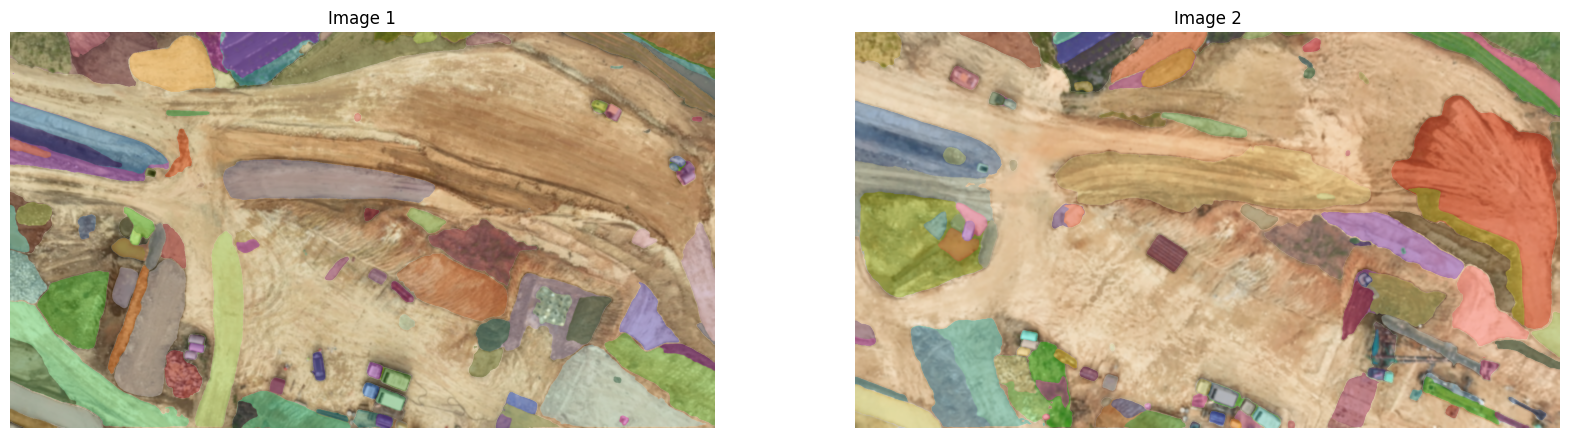

In [102]:
# [Test] SAM Auto Mask Generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    # crop_n_layers=1,
    # crop_n_points_downscale_factor=2,
    # min_mask_region_area=100,  # Requires open-cv to run post-processing
)


image1 = cv2.imread('/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/raw_images/frame_00099.png')
image2 = cv2.imread('/data/wpals113/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/renders/frame_00099.jpg')

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image1 =cv2.resize(image1, (image1.shape[1]//2, image1.shape[0]//2))
image2 =cv2.resize(image2, (image2.shape[1]//2, image2.shape[0]//2))

# gaussian blurring
image1 = cv2.GaussianBlur(image1, (0, 0), 2)
image2 = cv2.GaussianBlur(image2, (0, 0), 2)

masks1 = mask_generator.generate(image1)
masks2 = mask_generator.generate(image2)

# 시각화
plt.figure(figsize=(20, 10))

# 원본 이미지 1
plt.subplot(1, 2, 1)
plt.imshow(image1)
show_anns(masks1)
plt.title("Image 1")
plt.axis('off')

# 원본 이미지 2
plt.subplot(1, 2, 2)
plt.imshow(image2) 
show_anns(masks2)
plt.title("Image 2")
plt.axis('off')

In [87]:
print(len(masks1))
print(masks1[0]["segmentation"].shape)
print(masks1[0]["area"])
print(masks1[0]["bbox"])
print(masks1[0]["predicted_iou"])
print(masks1[0]["point_coords"])
print(masks1[0]["stability_score"])
print(masks1[0]["crop_box"])

95
(2160, 3840)
7098323
[0, 12, 3839, 2144]
1.00749933719635
[[510.0, 961.875]]
0.950070858001709
[0, 0, 3840, 2160]


In [1]:
# [Change Detection] GT mask visualization
import os
import cv2
import numpy as np
from glob import glob

# 디렉토리 설정
base_dir = '/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Duraemidam_ChangeDetection_workspace/trial4/CD_PAIR/test2/outputs/GT/train'
images_dir = os.path.join(base_dir, 'images')
labels_dir = os.path.join(base_dir, 'labels')
rgb_masks_dir = os.path.join(base_dir, 'masks/rgb_masks')
binary_masks_dir = os.path.join(base_dir, 'masks/binary_masks')
os.makedirs(rgb_masks_dir, exist_ok=True)
os.makedirs(binary_masks_dir, exist_ok=True)

# 클래스 색상 정의 (최대 10개 클래스 예시)
CLASS_COLORS = {
    0: (0, 225, 127),     # 빨강
    1: (0, 127, 255),     # 초록
    2: (0, 255, 255),     # 파랑
    3: (255, 0, 0),   # 노랑
    4: (255, 0, 255),   # 보라
    5: (0, 0, 255),   # 시안
    6: (255, 127, 0),
    7: (127, 0, 255),
    8: (0, 127, 255),
    9: (127, 127, 127)
}

# 이미지 목록 가져오기
image_paths = glob(os.path.join(images_dir, '*.jpg')) + glob(os.path.join(images_dir, '*.png'))

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + '.txt')

    # 이미지 불러오기
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # 마스크 초기화 (검정)
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # Binary 마스크 초기화 (0 = 배경)
    binary_mask = np.zeros((h, w), dtype=np.uint8)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.strip().split()))
                cls = int(parts[0])
                coords = parts[1:]

                # 정점 추출 및 스케일 복원
                polygon = []
                for i in range(0, len(coords), 2):
                    x = int(coords[i] * w)
                    y = int(coords[i+1] * h)
                    polygon.append([x, y])

                polygon = np.array([polygon], dtype=np.int32)

                # 마스크에 다각형 그리기
                color = CLASS_COLORS.get(cls, (255, 255, 255))  # 정의되지 않은 클래스는 흰색
                cv2.fillPoly(rgb_mask, polygon, color)

                # Binary 마스크에 흰색 채우기 (객체 영역)
                cv2.fillPoly(binary_mask, polygon, 255)

    # 마스크 저장
    rgb_mask_save_path = os.path.join(rgb_masks_dir, img_name)    
    cv2.imwrite(rgb_mask_save_path, rgb_mask)

    binary_mask_save_path = os.path.join(binary_masks_dir, img_name)
    cv2.imwrite(binary_mask_save_path, binary_mask)

print("모든 마스크가 생성되었습니다.")


모든 마스크가 생성되었습니다.


In [3]:
# GT Integrated mask (debut, retirement)

import os
import cv2
import numpy as np
from collections import defaultdict

# 경로 설정
base_dir = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Duraemidam_ChangeDetection_workspace/trial4/CD_PAIR/test2"

images_dir = os.path.join(base_dir, 'outputs/GT/train/images')
homography_dir = os.path.join(base_dir, "outputs/pred/homography")
binary_masks_dir = os.path.join(base_dir, 'outputs/GT/train/masks/binary_masks')
output_dir = os.path.join(base_dir, 'outputs/GT/train/masks/integrated_masks')

output_dir_blend = os.path.join(output_dir, "blend")
output_dir_rgb_mask = os.path.join(output_dir, "rgb")
output_dir_bi_mask = os.path.join(output_dir, "binary")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_blend, exist_ok=True)
os.makedirs(output_dir_rgb_mask, exist_ok=True)
os.makedirs(output_dir_bi_mask, exist_ok=True)

# 마스크 파일 분류
mask_files = os.listdir(binary_masks_dir)
grouped_masks = defaultdict(dict)

for file in mask_files:
    if not file.endswith(('.jpg', '.png')):
        continue

    if file.startswith('initial_paired_'):
        frame_key = file.split('_', 2)[2].split('_jpg')[0]  # "frame_00055"
        print(frame_key)
        grouped_masks[frame_key]['red'] = file
    else:
        frame_key = file.split('_', 1)[1].split('.')[0].split('_jpg')[0]  # "00055"
        # frame_key = 'frame_' + frame_key
        print(frame_key)
        grouped_masks[frame_key]['blue'] = file

# 마스크 결합
for frame_key, masks in grouped_masks.items():
    red_path = masks.get('red')
    blue_path = masks.get('blue')

    red_mask = None
    blue_mask = None

    if red_path:
        red_mask = cv2.imread(os.path.join(binary_masks_dir, red_path), cv2.IMREAD_GRAYSCALE)

    if blue_path:
        blue_mask = cv2.imread(os.path.join(binary_masks_dir, blue_path), cv2.IMREAD_GRAYSCALE)

    if red_mask is None and blue_mask is None:
        continue
    
    homography_12 = np.load(os.path.join(homography_dir, f"{frame_key}.npy"))

    if red_mask is not None:
        h, w = red_mask.shape
    else:
        h, w = blue_mask.shape

    integrated_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # 빨간색 먼저 적용
    if red_mask is not None:
        # red_mask_warped = cv2.warpPerspective(red_mask, homography_12, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0) 
        integrated_mask[red_mask > 0] = (75, 75, 225)  # 빨강 (BGR)                        

    # 파란색이 있는 픽셀은 무조건 덮어쓰기 (우선순위 높음)
    if blue_mask is not None:
        integrated_mask[blue_mask > 0] = (255, 75, 75)  # 파랑 (BGR)
    
    output_path = os.path.join(output_dir_rgb_mask, f"{frame_key}.jpg")
    cv2.imwrite(output_path, integrated_mask)

    ########################
    # ✅ 0, 255 바이너리 마스크 생성 및 저장
    binary_mask = np.zeros((h, w), dtype=np.uint8)

    if red_mask is not None:
        binary_mask[red_mask > 0] = 255

    if blue_mask is not None:
        binary_mask[blue_mask > 0] = 255  # 덮어쓰기, 파란색 우선 아님
        
    output_bin_path = os.path.join(output_dir_bi_mask, f"{frame_key}.png")
    cv2.imwrite(output_bin_path, binary_mask)

    ########################
    # Blending (원본 이미지에 변화 부분 표현하기)

    t1_image_path = os.path.join(images_dir, red_path)
    t2_image_path = os.path.join(images_dir, blue_path)        
            
    if t1_image_path is None:
        print(f"[!] 이미지 누락: {red_path}")
        continue
    if t2_image_path is None:
        print(f"[!] 이미지 누락: {blue_path}")
        continue

    t1_image = cv2.imread(t1_image_path)
    t2_image = cv2.imread(t2_image_path)
    h, w = t2_image.shape[:2]

    
    t1_blend_mask = np.zeros((h, w, 3), dtype=np.uint8)
    t2_blend_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # 빨간색 먼저 적용
    if red_mask is not None:                     
        t1_blend_mask[red_mask > 0] = (75, 75, 225)  

    # 파란색이 있는 픽셀은 무조건 덮어쓰기 (우선순위 높음)
    if blue_mask is not None:        
        t2_blend_mask[blue_mask > 0] = (255, 75, 75) 

     # 알파 블렌딩
    alpha = 0.5  # 투명도 0.0 ~ 1.0
    t1_blended = cv2.addWeighted(t1_image, 1.0, t1_blend_mask, alpha, 0)
    t2_blended = cv2.addWeighted(t2_image, 1.0, t2_blend_mask, alpha, 0)

    # 저장
    output_path = os.path.join(output_dir_blend, f"{red_path}")
    cv2.imwrite(output_path, t1_blended)
    output_path = os.path.join(output_dir_blend, f"{blue_path}")
    cv2.imwrite(output_path, t2_blended)

    

print("✅ 파란색 우선 통합 마스크가 integrated_masks 폴더에 저장되었습니다.")


frame_00005
frame_00007
frame_00011
frame_00021
frame_00025
frame_00005
frame_00007
frame_00011
frame_00021
frame_00025
✅ 파란색 우선 통합 마스크가 integrated_masks 폴더에 저장되었습니다.


In [13]:
# Prediction -> make binary mask folder 

import os
import shutil

def copy_images_to_folder(src_folders, dst_folder, image_extensions=None):
    if image_extensions is None:
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

    # 목적지 폴더가 없으면 생성
    os.makedirs(dst_folder, exist_ok=True)

    for folder in src_folders:
        if not os.path.isdir(folder):
            print(f"Warning: '{folder}' is not a directory or does not exist.")
            continue

        for filename in os.listdir(folder):
            ext = os.path.splitext(filename)[1].lower()
            if ext in image_extensions:
                src_path = os.path.join(folder, filename)
                dst_path = os.path.join(dst_folder, filename)

                # 이름 중복 처리: 덮어쓰거나, 이름 바꾸기 등
                if os.path.exists(dst_path):
                    base, ext = os.path.splitext(filename)
                    i = 1
                    while os.path.exists(dst_path):
                        dst_path = os.path.join(dst_folder, f"{base}{ext}")
                        i += 1

                shutil.copy2(src_path, dst_path)

    print(f"이미지 복사가 완료되었습니다. → {dst_folder}")

# 사용 예시
folder_a = '/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Sintanjin_80m_CD_workspace/longlong_trial1/CD_PAIR/test2/outputs/pred/debut'
folder_b = '/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Sintanjin_80m_CD_workspace/longlong_trial1/CD_PAIR/test2/outputs/pred/retirement'
folder_c = '/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Sintanjin_80m_CD_workspace/longlong_trial1/CD_PAIR/test2/outputs/pred/masks/binary_masks'


copy_images_to_folder([folder_a, folder_b], folder_c)

이미지 복사가 완료되었습니다. → /workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Sintanjin_80m_CD_workspace/longlong_trial1/CD_PAIR/test2/outputs/pred/masks/binary_masks


In [ ]:
# Integrated mask for prediction (debut, retirement)

import os
import cv2
import numpy as np
from collections import defaultdict

# 경로 설정
base_dir = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Sintanjin_80m_CD_workspace/longlong_trial1/CD_PAIR/test2"
images_dir = os.path.join(base_dir, 'nerf_cd_pair/raw')
homography_dir = os.path.join(base_dir, "outputs/pred/homography")
binary_masks_dir = os.path.join(base_dir, 'outputs/pred/masks/binary_masks')
output_dir = os.path.join(base_dir, 'outputs/pred/masks/integrated_masks')

output_dir_blend = os.path.join(output_dir, "blend")
output_dir_rgb_mask = os.path.join(output_dir, "rgb")
output_dir_bi_mask = os.path.join(output_dir, "binary")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_blend, exist_ok=True)
os.makedirs(output_dir_rgb_mask, exist_ok=True)
os.makedirs(output_dir_bi_mask, exist_ok=True)

# 마스크 파일 분류
mask_files = os.listdir(binary_masks_dir)
grouped_masks = defaultdict(dict)

for file in mask_files:
    if not file.endswith(('.jpg', '.png')):
        continue

    if file.startswith('initial_paired_'):
        frame_key = file.split('_', 2)[2].split('.')[0]  # "frame_00055"

        grouped_masks[frame_key]['red'] = file
    else:
        frame_key = file.split('_', 1)[1].split('.')[0]  # "00055"        

        grouped_masks[frame_key]['blue'] = file

# 마스크 결합
for frame_key, masks in grouped_masks.items():
    red_path = masks.get('red')
    blue_path = masks.get('blue')


    red_mask = None
    blue_mask = None
    
    if red_path:
        red_mask = cv2.imread(os.path.join(binary_masks_dir, red_path), cv2.IMREAD_GRAYSCALE)

    if blue_path:
        blue_mask = cv2.imread(os.path.join(binary_masks_dir, blue_path), cv2.IMREAD_GRAYSCALE)

    if red_mask is None and blue_mask is None:
        continue
    
    homography_12 = np.load(os.path.join(homography_dir, f"{frame_key}.npy"))
    
    if red_mask is not None:
        h, w = red_mask.shape
    else:
        h, w = blue_mask.shape

    integrated_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # 빨간색 먼저 적용
    if red_mask is not None:        
        integrated_mask[red_mask > 0] = (75, 75, 225)  # 빨강 (BGR)        

    # 파란색이 있는 픽셀은 무조건 덮어쓰기 (우선순위 높음)
    if blue_mask is not None:
        integrated_mask[blue_mask > 0] = (255, 75, 75)  # 파랑 (BGR)        

    output_path = os.path.join(output_dir, f"{frame_key}.jpg")
    cv2.imwrite(output_path, integrated_mask)

    ########################
    # Blending (원본 이미지에 변화 부분 표현하기)
    
    t1_image_path = os.path.join(images_dir, red_path)
    t2_image_path = os.path.join(images_dir, blue_path)        
            
    if t1_image_path is None:
        print(f"[!] 이미지 누락: {red_path}")
        continue
    if t2_image_path is None:
        print(f"[!] 이미지 누락: {blue_path}")
        continue

    t1_image = cv2.imread(t1_image_path)
    t2_image = cv2.imread(t2_image_path)
    h, w = t2_image.shape[:2]        

    
    t1_blend_mask = np.zeros((h, w, 3), dtype=np.uint8)
    t2_blend_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # 빨간색 먼저 적용
    if red_mask is not None:        
        red_mask_unwarped = cv2.warpPerspective(red_mask, np.linalg.inv(homography_12), (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=0) 
        t1_blend_mask[red_mask_unwarped > 0] = (75, 75, 225)  

    # 파란색이 있는 픽셀은 무조건 덮어쓰기 (우선순위 높음)
    if blue_mask is not None:        
        t2_blend_mask[blue_mask > 0] = (255, 75, 75) 

     # 알파 블렌딩
    alpha = 0.5  # 투명도 0.0 ~ 1.0
    t1_blended = cv2.addWeighted(t1_image, 1.0, t1_blend_mask, alpha, 0)
    t2_blended = cv2.addWeighted(t2_image, 1.0, t2_blend_mask, alpha, 0)

    # 저장
    output_path = os.path.join(output_dir_blend, f"{red_path}")
    cv2.imwrite(output_path, t1_blended)
    output_path = os.path.join(output_dir_blend, f"{blue_path}")
    cv2.imwrite(output_path, t2_blended)


print("✅ 파란색 우선 통합 마스크가 integrated_masks 폴더에 저장되었습니다.")


✅ 파란색 우선 통합 마스크가 integrated_masks 폴더에 저장되었습니다.
